In [1]:
%pylab inline
from qutip import *
#import the qutip package

Populating the interactive namespace from numpy and matplotlib


In [2]:
#gamma1 = 2/45900.
gamma1 = 2/45900.
gamma2 = 1/38100.
gamma_cnot = 1/46611.
gamma_cnot = 4/46611.
cnot_time = 364
#cnot_time = 364
#gamma1 =0.
#gamma2 = 0.
#Noise paramters and the gate time are determined in here.

lam = pi/(4.*60.)
def drive(t,args):
    return cos(t)
def drive(t,args):
    return 1.
N = 4

si = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = destroy(2).dag()
x_p = (basis(2,0)+basis(2,1))/sqrt(2)

up = basis(2,0)*basis(2,0).dag()
down = basis(2,1)*basis(2,1).dag()

x_m = (basis(2,0)-basis(2,1))/sqrt(2)
Hada = x_p*basis(2,1).dag() + x_m*basis(2,0).dag()

theta = pi/2.
theta_list = np.linspace(0,pi/2,30)
thi =0.
lam = 0.

Qw2 = []
#I change this so that it is ordered like in the manuscript (there my basis(2,0) is basis(2,1), gah)

#U3 = (np.cos(theta/2.)*basis(2,0)*basis(2,0).dag() 
#    + np.exp(1.0j*(lam+thi))*np.cos(theta/2.)*basis(2,1)*basis(2,1).dag()
#    - np.exp(1.0j*(lam))*np.sin(theta/2.)*basis(2,0)*basis(2,1).dag()
#    + np.exp(1.0j*(thi))*np.sin(theta/2.)*basis(2,1)*basis(2,0).dag())

for theta in theta_list:

    U3 = (np.cos(theta/2.)*basis(2,1)*basis(2,1).dag() 
        + np.exp(1.0j*(lam+thi))*np.cos(theta/2.)*basis(2,0)*basis(2,0).dag()
        - np.exp(1.0j*(lam))*np.sin(theta/2.)*basis(2,1)*basis(2,0).dag()
        + np.exp(1.0j*(thi))*np.sin(theta/2.)*basis(2,0)*basis(2,1).dag())

    sx_list = []
    sy_list = []
    sz_list = []
    sm_list = []
    Hada_list = []
    U3_list = []
    Cnot_list = []
    up_list = []
    down_list = []
    unit_list = []
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

        op_list[n] = sm
        sm_list.append(tensor(op_list))

        op_list[n] = up
        up_list.append(tensor(op_list))

        op_list[n] = down
        down_list.append(tensor(op_list))

        op_list[n] = Hada

        Hada_list.append(tensor(op_list))

        op_list[n] = U3

        U3_list.append(tensor(op_list))

        op_list[n] = si
        unit_list.append(tensor(op_list))
    cnot_list =np.empty( (N,N), dtype=object )

    for n in range(N):
        for m in range(N):
            if n!=m:
                #I change this so that it flips when the qubit is excited in the z-basis. urgh
                #other wise we get the wrong final state
                #cnot_list[n,m] = up_list[n] + down_list[n]*sx_list[m]
                cnot_list[n,m] = down_list[n] + up_list[n]*sx_list[m]
#We set the quantum gate we would use here

    optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-14,atol=1e-14)



    #stupid
    H = 0 * sy_list[0]

    # interaction terms
    #for n in range(N-1):
    #    H += - 0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    #    H += - 0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    #    H += - 0.5 * Jz[n] * sz_list[n] * sz_list[n+1]

    c_op_list = []
    c_op_list2 = []
    gamma1_list = [gamma1 for n in range(N)]
    gamma2_list = [gamma2 for n in range(N)]

    for n in range(N):
            if gamma1_list[n] > 0.0:
                c_op_list.append(np.sqrt(gamma1_list[n]) * sm_list[n])                
                #c_op_list2.append(np.sqrt(0.3*gamma1_list[n]) * sm_list[n].dag())                
            if gamma2_list[n] > 0.0:
                c_op_list.append(np.sqrt(gamma2_list[n]) * sz_list[n])
#Set the Lindblad operator

    # intial state, all spins in ground state
    psi_list = []
    psi_list.append(basis(2,1))
    for n in range(N-1):
        psi_list.append(basis(2,1))

    psi0 = tensor(psi_list)

    mesolve_states_tot = []

    #U3 rotation 
    #U3 1 time

    #tlist_hada = np.linspace(0, 100, 100)
    tlist_U3 = np.linspace(0, 130+2*60, 130+2*60)
    psi0 = U3_list[0] * psi0 * psi0.dag() * U3_list[0].dag()

    mesolve_avr = mesolve(H,psi0,tlist_U3,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 




    #c_not 1
    #c_not 1 time
    cnot12t = cnot_time
    tlist_cnot = np.linspace(0, cnot12t , cnot12t )
    psi0 = cnot_list[0,1] * psi0 * cnot_list[0,1].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 

    """
    #Unitary evolution... violation decreases?
    #c_not 2 measurement 
    cnot13t = 300 + 2*652
    tlist_cnot = np.linspace(0, cnot13t, cnot13t)
    #psi0 = cnot_list[0,2] * psi0 * cnot_list[0,2].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 



    #c_not 3 measurement 
    cnot24t = 300 + 2*1043
    tlist_cnot = np.linspace(0, cnot24t , cnot24t )
    #psi0 = cnot_list[1,3] * psi0 * cnot_list[1,3].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 
    """

    #c_not 4 inverse
    cnot12t = cnot_time
    tlist_cnot = np.linspace(0, cnot12t, cnot12t)
    psi0 = cnot_list[0,1] * psi0 * cnot_list[0,1].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    #U3 rotation inverse
    #tlist_hada = np.linspace(0, 100, 100)
    tlist_U3 = np.linspace(0, 130, 130)
    psi0 = U3_list[0].dag() * psi0 * U3_list[0]
    mesolve_avr = mesolve(H,psi0,tlist_U3,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 




    P00=(tensor(basis(2,1)*basis(2,1).dag(),basis(2,1)*basis(2,1).dag(),qeye(2),qeye(2)))



    #no measurement probability
    Pt300=(expect(mesolve_avr.states[-1] ,P00))



# In the following, we consider the ancilla to obtain the two-time correlation function
    #stupid
    H = 0 * sy_list[0]

    # interaction terms
    #for n in range(N-1):
    #    H += - 0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    #    H += - 0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    #    H += - 0.5 * Jz[n] * sz_list[n] * sz_list[n+1]

    c_op_list = []

    gamma1_list = [gamma1 for n in range(N)]
    gamma2_list = [gamma2 for n in range(N)]



    # intial state, all spins in ground state
    psi_list = []
    psi_list.append(basis(2,1))
    for n in range(N-1):
        psi_list.append(basis(2,1))

    psi0 = tensor(psi_list)

    mesolve_states_tot = []

    #U3 rotation
    #tlist_hada = np.linspace(0, 100, 100)
    tlist_U3 = np.linspace(0, 130+2*60, 130+2*60)
    psi0 = U3_list[0] * psi0 * psi0.dag() * U3_list[0].dag()

    mesolve_avr = mesolve(H,psi0,tlist_U3,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 




    #c_not 1
    cnot12t = cnot_time
    tlist_cnot = np.linspace(0,cnot12t, cnot12t)
    psi0 = cnot_list[0,1] * psi0 * cnot_list[0,1].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    #c_not 2 measurement 
    cnot13t = cnot_time
    tlist_cnot = np.linspace(0, cnot13t, cnot13t)
    psi0 = cnot_list[0,2] * psi0 * cnot_list[0,2].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list+[sqrt(gamma_cnot)*sm_list[0].dag(),sqrt(gamma_cnot)*sm_list[2].dag()],options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    #c_not 3 measurement 
    cnot24t = cnot_time
    tlist_cnot = np.linspace(0, cnot24t , cnot24t )
    psi0 = cnot_list[1,3] * psi0 * cnot_list[1,3].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list +[sqrt(gamma_cnot)*sm_list[1].dag(),sqrt(gamma_cnot)*sm_list[3].dag()],options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    #c_not 4 inverse
    cnot12t = cnot_time
    tlist_cnot = np.linspace(0, cnot12t, cnot12t)
    psi0 = cnot_list[0,1] * psi0 * cnot_list[0,1].dag()

    mesolve_avr = mesolve(H,psi0,tlist_cnot,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    #U3 rotation inverse
    #tlist_hada = np.linspace(0, 100, 100)
    tlist_U3 = np.linspace(0, 130+2*60, 130+2*60)
    psi0 = U3_list[0].dag() * psi0 * U3_list[0]
    mesolve_avr = mesolve(H,psi0,tlist_U3,c_op_list,options=optionsODE)
    mesolve_states_tot.extend(mesolve_avr.states)
    psi0 =  mesolve_avr.states[-1] 


    P00=(tensor(basis(2,1)*basis(2,1).dag(),basis(2,1)*basis(2,1).dag(),qeye(2),qeye(2)))

    #with measurement, sum correlators


    Pt2t300 =expect(mesolve_avr.states[-1] ,P00)


    Qw2.append(Pt300 - Pt2t300)

In [3]:
theta = pi/2.
theta_list2 = np.linspace(0,pi/2,5)
print(theta_list2)

[0.         0.39269908 0.78539816 1.17809725 1.57079633]


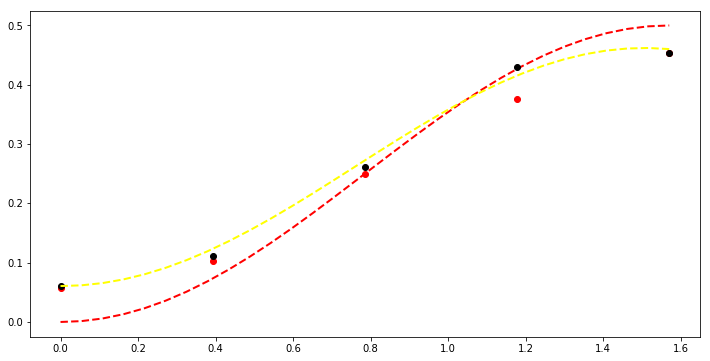

In [5]:


#unit  = expect(outputQ1.states, P1+P2+P3+P4)
#print(unit)
fig, axes2 = subplots(1, 1, sharex=True, figsize=(12,6))
PM = [0.061, 0.112, 0.261, 0.43, 0.454]
DI = [0.058, 0.102, 0.250, 0.376, 0.453]
Qwana = [1- cos(theta/2)**4 - sin(theta/2)**4 for theta in theta_list]


#axes2.plot(theta_list, real(Qw), 'black', linestyle='-', linewidth=2, label="normal")
axes2.plot(theta_list, real(Qwana), 'red', linestyle='--', linewidth=2, label="analytics")
axes2.plot(theta_list2, real(DI), 'red', marker='o',linestyle="None", label="IBM")
axes2.plot(theta_list2, real(PM), 'black', marker='o',linestyle="None", label="IBM")
axes2.plot(theta_list, real(Qw2), 'yellow', linestyle='--', linewidth=2, label="up and down")

#axes2.plot(tlist2, real(P80HEOM83), 'green', linestyle='--', linewidth=2, label="P1 HEOM 80")



#axes2.plot(tlist2, np.real(P12_average2), 'red', linestyle='--', label="artificial noise thing")
